Name: Shuai Zhao

uscid: 7722927131

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("CUDA available:", torch.cuda.is_available())


Using device: cuda
CUDA available: True


In [ ]:
class PINN_MLP(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, width=18, depth=6):
        super(PINN_MLP, self).__init__()
        layers = [nn.Linear(input_dim, width), nn.Tanh()]
        for _ in range(depth - 2):
            layers.extend([nn.Linear(width, width), nn.Tanh()])
        layers.append(nn.Linear(width, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
def initialize_model():
    model = PINN_MLP().to(device)
    for param in model.parameters():
        torch.nn.init.normal_(param, mean=0.0, std=1.0)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)

    print("Model is on device:", next(model.parameters()).device)
    return model, optimizer


In [ ]:
def pinn_loss(u_pred, x, Pe, Da, lb=10):
    u_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    residual = u_xx - Pe * u_x + Da * u_pred * (1 - u_pred)
    boundary_loss = lb * (u_pred[0]**2 + (u_pred[-1] - 1)**2)
    return (residual**2).mean() + boundary_loss


In [ ]:
def load_reference_data(Pe, Da):
    #  (Pe, Da) to filename
    file_map = {
        (0.01, 0.01): '/content/drive/My Drive/Assignment 04_DATA/Pe_001_Da_001.txt',
        (20, 0.01): '/content/drive/My Drive/Assignment 04_DATA/Pe_20_Da_001.txt',
        (0.01, 60): '/content/drive/My Drive/Assignment 04_DATA/Pe_001_Da_60.txt',
        (15, 40): '/content/drive/My Drive/Assignment 04_DATA/Pe_15_Da_40.txt'
    }

    file_path = file_map.get((Pe, Da))
    if not file_path:
        raise ValueError(f"No reference data file found for Pe={Pe}, Da={Da}")

    # load file
    data = np.loadtxt(file_path)
    test_points = torch.tensor(data[:, 0], dtype=torch.float32).view(-1, 1).to(device)
    reference_solution = data[:, 1]
    return test_points, reference_solution


In [ ]:
from tqdm import tqdm

def train(model, optimizer, epochs, Pe, Da, lb=10):
    history = {'interior_loss': [], 'boundary_loss': []}
    for epoch in tqdm(range(epochs), desc=f"Training (Pe={Pe}, Da={Da})", leave=True):
        optimizer.zero_grad()
        u_pred = model(x_train)
        loss = pinn_loss(u_pred, x_train, Pe, Da, lb)
        loss.backward()
        optimizer.step()

        # loss
        interior_loss = loss.item()
        boundary_loss = lb * ((u_pred[0]**2 + (u_pred[-1] - 1)**2).item())
        history['interior_loss'].append(interior_loss)
        history['boundary_loss'].append(boundary_loss)

        if epoch % 5000 == 0:
            print(f'Epoch {epoch}/{epochs} - Interior Loss: {interior_loss}, Boundary Loss: {boundary_loss}')

    return history


In [ ]:
N = 100
x_train = torch.linspace(0, 1, N).view(-1, 1).to(device)
x_train.requires_grad = True


In [47]:
lb_values = [10, 300, 10000]
param_sets = [
    (0.01, 0.01),  # Diffusion dominates
    (20, 0.01),    # Advection dominates
    (0.01, 60),    # Reaction dominates
    (15, 40)       # Advection and reaction dominate
]

results = {}

# train
for lb_value in lb_values:
    results[lb_value] = {}

    for Pe, Da in param_sets:
        test_points, reference_solution = load_reference_data(Pe, Da)

        model, optimizer = initialize_model()

        # start traning
        print(f"\nTraining for Pe={Pe}, Da={Da}, λb={lb_value}")
        history = train(model, optimizer, epochs=40000, Pe=Pe, Da=Da, lb=lb_value)

        # save data
        u_pred = model(test_points).detach().cpu().numpy()
        results[lb_value][(Pe, Da)] = {
            "history": history,
            "test_points": test_points.cpu().numpy(),
            "u_pred": u_pred,
            "reference_solution": reference_solution
        }

Model is on device: cuda:0

Training for Pe=0.01, Da=0.01, λb=10


Training (Pe=0.01, Da=0.01):   0%|          | 16/40000 [00:00<04:24, 150.97it/s]

Epoch 0/40000 - Interior Loss: 406.442626953125, Boundary Loss: 247.84326553344727


Training (Pe=0.01, Da=0.01):  13%|█▎        | 5032/40000 [00:32<03:41, 157.53it/s]

Epoch 5000/40000 - Interior Loss: 0.002785112475976348, Boundary Loss: 9.912430414260598e-06


Training (Pe=0.01, Da=0.01):  25%|██▌       | 10022/40000 [01:04<03:11, 156.89it/s]

Epoch 10000/40000 - Interior Loss: 0.00015584210632368922, Boundary Loss: 2.0827428670600057e-09


Training (Pe=0.01, Da=0.01):  38%|███▊      | 15018/40000 [01:36<02:42, 153.56it/s]

Epoch 15000/40000 - Interior Loss: 6.291232421062887e-05, Boundary Loss: 1.986393272090936e-09


Training (Pe=0.01, Da=0.01):  50%|█████     | 20026/40000 [02:09<02:09, 153.91it/s]

Epoch 20000/40000 - Interior Loss: 7.351187377935275e-05, Boundary Loss: 2.0120749013585737e-05


Training (Pe=0.01, Da=0.01):  63%|██████▎   | 25021/40000 [02:41<01:36, 155.21it/s]

Epoch 25000/40000 - Interior Loss: 6.989281700953143e-06, Boundary Loss: 9.833911462919787e-11


Training (Pe=0.01, Da=0.01):  75%|███████▌  | 30023/40000 [03:13<01:04, 154.27it/s]

Epoch 30000/40000 - Interior Loss: 2.7672292617353378e-06, Boundary Loss: 1.6218848486460047e-09


Training (Pe=0.01, Da=0.01):  88%|████████▊ | 35017/40000 [03:45<00:31, 155.93it/s]

Epoch 35000/40000 - Interior Loss: 0.00022367607743944973, Boundary Loss: 1.5211616073429468e-05


Training (Pe=0.01, Da=0.01): 100%|██████████| 40000/40000 [04:17<00:00, 155.54it/s]


Model is on device: cuda:0

Training for Pe=20, Da=0.01, λb=10


Training (Pe=20, Da=0.01):   0%|          | 16/40000 [00:00<04:17, 155.17it/s]

Epoch 0/40000 - Interior Loss: 77772.78125, Boundary Loss: 233.0791473388672


Training (Pe=20, Da=0.01):  13%|█▎        | 5028/40000 [00:32<03:45, 155.24it/s]

Epoch 5000/40000 - Interior Loss: 2.657271146774292, Boundary Loss: 1.7477594316005707


Training (Pe=20, Da=0.01):  25%|██▌       | 10021/40000 [01:04<03:16, 152.62it/s]

Epoch 10000/40000 - Interior Loss: 0.06515147536993027, Boundary Loss: 0.0041138322558254


Training (Pe=20, Da=0.01):  38%|███▊      | 15029/40000 [01:36<02:37, 158.26it/s]

Epoch 15000/40000 - Interior Loss: 0.008403077721595764, Boundary Loss: 8.633400284452364e-05


Training (Pe=20, Da=0.01):  50%|█████     | 20024/40000 [02:08<02:10, 153.08it/s]

Epoch 20000/40000 - Interior Loss: 0.002811938989907503, Boundary Loss: 1.6872290871106088e-05


Training (Pe=20, Da=0.01):  63%|██████▎   | 25020/40000 [02:40<01:35, 156.82it/s]

Epoch 25000/40000 - Interior Loss: 0.001579025643877685, Boundary Loss: 1.3080968983558705e-05


Training (Pe=20, Da=0.01):  75%|███████▌  | 30025/40000 [03:13<01:04, 154.03it/s]

Epoch 30000/40000 - Interior Loss: 0.0009510986274108291, Boundary Loss: 2.5382996682310477e-06


Training (Pe=20, Da=0.01):  88%|████████▊ | 35018/40000 [03:45<00:32, 151.50it/s]

Epoch 35000/40000 - Interior Loss: 0.0005547590553760529, Boundary Loss: 1.3508270058082417e-06


Training (Pe=20, Da=0.01): 100%|██████████| 40000/40000 [04:17<00:00, 155.37it/s]


Model is on device: cuda:0

Training for Pe=0.01, Da=60, λb=10


Training (Pe=0.01, Da=60):   0%|          | 16/40000 [00:00<04:16, 155.99it/s]

Epoch 0/40000 - Interior Loss: 1543963.875, Boundary Loss: 23.6049747467041


Training (Pe=0.01, Da=60):  13%|█▎        | 5027/40000 [00:32<03:43, 156.55it/s]

Epoch 5000/40000 - Interior Loss: 22.887447357177734, Boundary Loss: 5.452557802200317


Training (Pe=0.01, Da=60):  25%|██▌       | 10032/40000 [01:04<03:15, 153.46it/s]

Epoch 10000/40000 - Interior Loss: 0.5723307132720947, Boundary Loss: 0.09240459650754929


Training (Pe=0.01, Da=60):  38%|███▊      | 15019/40000 [01:36<02:37, 158.63it/s]

Epoch 15000/40000 - Interior Loss: 0.027941711246967316, Boundary Loss: 2.9442471713991836e-05


Training (Pe=0.01, Da=60):  50%|█████     | 20028/40000 [02:08<02:09, 154.54it/s]

Epoch 20000/40000 - Interior Loss: 0.009621545672416687, Boundary Loss: 7.61097169288405e-06


Training (Pe=0.01, Da=60):  63%|██████▎   | 25028/40000 [02:40<01:38, 151.60it/s]

Epoch 25000/40000 - Interior Loss: 0.03768087550997734, Boundary Loss: 0.00013372959074331447


Training (Pe=0.01, Da=60):  75%|███████▌  | 30028/40000 [03:12<01:03, 156.80it/s]

Epoch 30000/40000 - Interior Loss: 0.0034675784409046173, Boundary Loss: 1.3284505939736846e-06


Training (Pe=0.01, Da=60):  88%|████████▊ | 35023/40000 [03:44<00:31, 157.13it/s]

Epoch 35000/40000 - Interior Loss: 0.0023236903361976147, Boundary Loss: 2.386244091212575e-07


Training (Pe=0.01, Da=60): 100%|██████████| 40000/40000 [04:16<00:00, 155.95it/s]


Model is on device: cuda:0

Training for Pe=15, Da=40, λb=10


Training (Pe=15, Da=40):   0%|          | 15/40000 [00:00<04:27, 149.26it/s]

Epoch 0/40000 - Interior Loss: 2436228.25, Boundary Loss: 235.36396026611328


Training (Pe=15, Da=40):  13%|█▎        | 5023/40000 [00:32<03:49, 152.66it/s]

Epoch 5000/40000 - Interior Loss: 223.640869140625, Boundary Loss: 81.48624420166016


Training (Pe=15, Da=40):  25%|██▌       | 10029/40000 [01:04<03:11, 156.61it/s]

Epoch 10000/40000 - Interior Loss: 41.45964050292969, Boundary Loss: 26.5164852142334


Training (Pe=15, Da=40):  38%|███▊      | 15024/40000 [01:36<02:43, 152.41it/s]

Epoch 15000/40000 - Interior Loss: 2.6253209114074707, Boundary Loss: 0.9625521302223206


Training (Pe=15, Da=40):  50%|█████     | 20021/40000 [02:08<02:07, 156.27it/s]

Epoch 20000/40000 - Interior Loss: 1.0635392665863037, Boundary Loss: 0.5420520156621933


Training (Pe=15, Da=40):  63%|██████▎   | 25020/40000 [02:40<01:35, 156.81it/s]

Epoch 25000/40000 - Interior Loss: 17.279470443725586, Boundary Loss: 0.44922400265932083


Training (Pe=15, Da=40):  75%|███████▌  | 30029/40000 [03:12<01:05, 151.97it/s]

Epoch 30000/40000 - Interior Loss: 0.5588122010231018, Boundary Loss: 0.34838106483221054


Training (Pe=15, Da=40):  88%|████████▊ | 35019/40000 [03:44<00:31, 155.69it/s]

Epoch 35000/40000 - Interior Loss: 0.39326369762420654, Boundary Loss: 0.27337465435266495


Training (Pe=15, Da=40): 100%|██████████| 40000/40000 [04:16<00:00, 155.83it/s]


Model is on device: cuda:0

Training for Pe=0.01, Da=0.01, λb=300


Training (Pe=0.01, Da=0.01):   0%|          | 16/40000 [00:00<04:17, 155.05it/s]

Epoch 0/40000 - Interior Loss: 65026.75, Boundary Loss: 7004.403305053711


Training (Pe=0.01, Da=0.01):  13%|█▎        | 5025/40000 [00:32<03:50, 151.41it/s]

Epoch 5000/40000 - Interior Loss: 2.310673236846924, Boundary Loss: 0.025767875922610983


Training (Pe=0.01, Da=0.01):  25%|██▌       | 10029/40000 [01:04<03:13, 155.25it/s]

Epoch 10000/40000 - Interior Loss: 0.047907307744026184, Boundary Loss: 1.9653833760457928e-05


Training (Pe=0.01, Da=0.01):  38%|███▊      | 15019/40000 [01:36<02:39, 156.50it/s]

Epoch 15000/40000 - Interior Loss: 0.0064805010333657265, Boundary Loss: 0.0002165913315366197


Training (Pe=0.01, Da=0.01):  50%|█████     | 20017/40000 [02:08<02:11, 152.47it/s]

Epoch 20000/40000 - Interior Loss: 0.002663159277290106, Boundary Loss: 2.7698376925400225e-06


Training (Pe=0.01, Da=0.01):  63%|██████▎   | 25030/40000 [02:40<01:35, 157.50it/s]

Epoch 25000/40000 - Interior Loss: 0.0016262414865195751, Boundary Loss: 0.0001389992291933595


Training (Pe=0.01, Da=0.01):  75%|███████▌  | 30029/40000 [03:12<01:04, 155.62it/s]

Epoch 30000/40000 - Interior Loss: 0.001073752180673182, Boundary Loss: 0.00010621988622006029


Training (Pe=0.01, Da=0.01):  88%|████████▊ | 35027/40000 [03:45<00:32, 152.52it/s]

Epoch 35000/40000 - Interior Loss: 0.0006576421437785029, Boundary Loss: 4.7126718527579214e-06


Training (Pe=0.01, Da=0.01): 100%|██████████| 40000/40000 [04:17<00:00, 155.63it/s]


Model is on device: cuda:0

Training for Pe=20, Da=0.01, λb=300


Training (Pe=20, Da=0.01):   0%|          | 15/40000 [00:00<04:28, 148.76it/s]

Epoch 0/40000 - Interior Loss: 89075.515625, Boundary Loss: 23433.02764892578


Training (Pe=20, Da=0.01):  13%|█▎        | 5023/40000 [00:32<03:42, 157.53it/s]

Epoch 5000/40000 - Interior Loss: 17.61564826965332, Boundary Loss: 5.6787243112921715


Training (Pe=20, Da=0.01):  25%|██▌       | 10018/40000 [01:04<03:13, 154.83it/s]

Epoch 10000/40000 - Interior Loss: 0.09299974888563156, Boundary Loss: 0.00016210657349802204


Training (Pe=20, Da=0.01):  38%|███▊      | 15023/40000 [01:36<02:41, 154.27it/s]

Epoch 15000/40000 - Interior Loss: 0.01805434748530388, Boundary Loss: 0.003535496307449648


Training (Pe=20, Da=0.01):  50%|█████     | 20028/40000 [02:08<02:08, 155.68it/s]

Epoch 20000/40000 - Interior Loss: 0.001714064972475171, Boundary Loss: 0.000262503328940511


Training (Pe=20, Da=0.01):  63%|██████▎   | 25024/40000 [02:40<01:36, 154.83it/s]

Epoch 25000/40000 - Interior Loss: 0.0028081927448511124, Boundary Loss: 8.35790103792533e-05


Training (Pe=20, Da=0.01):  75%|███████▌  | 30021/40000 [03:12<01:04, 155.92it/s]

Epoch 30000/40000 - Interior Loss: 0.0004917305195704103, Boundary Loss: 2.4039462687142077e-05


Training (Pe=20, Da=0.01):  88%|████████▊ | 35024/40000 [03:45<00:31, 156.39it/s]

Epoch 35000/40000 - Interior Loss: 0.00030742993112653494, Boundary Loss: 1.7190302514791256e-07


Training (Pe=20, Da=0.01): 100%|██████████| 40000/40000 [04:17<00:00, 155.52it/s]


Model is on device: cuda:0

Training for Pe=0.01, Da=60, λb=300


Training (Pe=0.01, Da=60):   0%|          | 16/40000 [00:00<04:18, 154.82it/s]

Epoch 0/40000 - Interior Loss: 1956089.25, Boundary Loss: 6540.423202514648


Training (Pe=0.01, Da=60):  13%|█▎        | 5024/40000 [00:32<03:42, 157.31it/s]

Epoch 5000/40000 - Interior Loss: 384.1142272949219, Boundary Loss: 16.48227944970131


Training (Pe=0.01, Da=60):  25%|██▌       | 10017/40000 [01:04<03:12, 155.70it/s]

Epoch 10000/40000 - Interior Loss: 32.03980255126953, Boundary Loss: 8.336121775209904


Training (Pe=0.01, Da=60):  38%|███▊      | 15032/40000 [01:36<02:38, 157.11it/s]

Epoch 15000/40000 - Interior Loss: 20.72322654724121, Boundary Loss: 3.7188523449003696


Training (Pe=0.01, Da=60):  50%|█████     | 20027/40000 [02:08<02:08, 155.37it/s]

Epoch 20000/40000 - Interior Loss: 20.573760986328125, Boundary Loss: 3.5568706691265106


Training (Pe=0.01, Da=60):  63%|██████▎   | 25023/40000 [02:40<01:34, 158.42it/s]

Epoch 25000/40000 - Interior Loss: 20.250123977661133, Boundary Loss: 3.546041250228882


Training (Pe=0.01, Da=60):  75%|███████▌  | 30027/40000 [03:12<01:04, 155.14it/s]

Epoch 30000/40000 - Interior Loss: 20.219905853271484, Boundary Loss: 3.5445258021354675


Training (Pe=0.01, Da=60):  88%|████████▊ | 35016/40000 [03:44<00:32, 151.86it/s]

Epoch 35000/40000 - Interior Loss: 20.2122802734375, Boundary Loss: 3.5427424125373363


Training (Pe=0.01, Da=60): 100%|██████████| 40000/40000 [04:16<00:00, 156.09it/s]


Model is on device: cuda:0

Training for Pe=15, Da=40, λb=300


Training (Pe=15, Da=40):   0%|          | 16/40000 [00:00<04:11, 158.74it/s]

Epoch 0/40000 - Interior Loss: 520004.53125, Boundary Loss: 2875.1927375793457


Training (Pe=15, Da=40):  13%|█▎        | 5024/40000 [00:32<03:43, 156.42it/s]

Epoch 5000/40000 - Interior Loss: 22.652746200561523, Boundary Loss: 1.3091790955513716


Training (Pe=15, Da=40):  25%|██▌       | 10016/40000 [01:04<03:16, 152.89it/s]

Epoch 10000/40000 - Interior Loss: 2.8904857635498047, Boundary Loss: 0.8952785516157746


Training (Pe=15, Da=40):  38%|███▊      | 15025/40000 [01:36<02:38, 157.46it/s]

Epoch 15000/40000 - Interior Loss: 0.3009335398674011, Boundary Loss: 0.10232199565507472


Training (Pe=15, Da=40):  50%|█████     | 20024/40000 [02:08<02:10, 153.64it/s]

Epoch 20000/40000 - Interior Loss: 1.2215787172317505, Boundary Loss: 0.011554583397810347


Training (Pe=15, Da=40):  63%|██████▎   | 25028/40000 [02:40<01:40, 148.59it/s]

Epoch 25000/40000 - Interior Loss: 0.045214228332042694, Boundary Loss: 0.003057268349948572


Training (Pe=15, Da=40):  75%|███████▌  | 30030/40000 [03:12<01:03, 156.29it/s]

Epoch 30000/40000 - Interior Loss: 0.030805500224232674, Boundary Loss: 0.00029424988952087006


Training (Pe=15, Da=40):  88%|████████▊ | 35021/40000 [03:45<00:31, 157.69it/s]

Epoch 35000/40000 - Interior Loss: 0.022896163165569305, Boundary Loss: 3.2526514814890106e-05


Training (Pe=15, Da=40): 100%|██████████| 40000/40000 [04:17<00:00, 155.61it/s]


Model is on device: cuda:0

Training for Pe=0.01, Da=0.01, λb=10000


Training (Pe=0.01, Da=0.01):   0%|          | 16/40000 [00:00<04:20, 153.49it/s]

Epoch 0/40000 - Interior Loss: 357874.09375, Boundary Loss: 109353.27529907227


Training (Pe=0.01, Da=0.01):  13%|█▎        | 5031/40000 [00:32<03:40, 158.63it/s]

Epoch 5000/40000 - Interior Loss: 24.71486473083496, Boundary Loss: 0.031236586437444203


Training (Pe=0.01, Da=0.01):  25%|██▌       | 10026/40000 [01:04<03:11, 156.27it/s]

Epoch 10000/40000 - Interior Loss: 0.621221661567688, Boundary Loss: 0.0023965986883922596


Training (Pe=0.01, Da=0.01):  38%|███▊      | 15031/40000 [01:36<02:42, 153.65it/s]

Epoch 15000/40000 - Interior Loss: 0.10441228002309799, Boundary Loss: 2.515619712539774e-05


Training (Pe=0.01, Da=0.01):  50%|█████     | 20023/40000 [02:08<02:07, 156.16it/s]

Epoch 20000/40000 - Interior Loss: 0.044099245220422745, Boundary Loss: 0.00011361443341684208


Training (Pe=0.01, Da=0.01):  63%|██████▎   | 25029/40000 [02:41<01:39, 150.28it/s]

Epoch 25000/40000 - Interior Loss: 0.46631020307540894, Boundary Loss: 0.05363943273550831


Training (Pe=0.01, Da=0.01):  75%|███████▌  | 30023/40000 [03:13<01:05, 152.23it/s]

Epoch 30000/40000 - Interior Loss: 0.026592830196022987, Boundary Loss: 0.000997510625211362


Training (Pe=0.01, Da=0.01):  88%|████████▊ | 35030/40000 [03:45<00:31, 155.35it/s]

Epoch 35000/40000 - Interior Loss: 0.2543066442012787, Boundary Loss: 0.031623865197616396


Training (Pe=0.01, Da=0.01): 100%|██████████| 40000/40000 [04:17<00:00, 155.19it/s]


Model is on device: cuda:0

Training for Pe=20, Da=0.01, λb=10000


Training (Pe=20, Da=0.01):   0%|          | 15/40000 [00:00<04:27, 149.59it/s]

Epoch 0/40000 - Interior Loss: 519675.25, Boundary Loss: 470551.7578125


Training (Pe=20, Da=0.01):  13%|█▎        | 5022/40000 [00:32<03:43, 156.17it/s]

Epoch 5000/40000 - Interior Loss: 56.79241943359375, Boundary Loss: 2.5923026259988546


Training (Pe=20, Da=0.01):  25%|██▌       | 10030/40000 [01:04<03:12, 155.83it/s]

Epoch 10000/40000 - Interior Loss: 0.8783674836158752, Boundary Loss: 0.003018668053300644


Training (Pe=20, Da=0.01):  38%|███▊      | 15021/40000 [01:37<02:42, 153.65it/s]

Epoch 15000/40000 - Interior Loss: 0.16896015405654907, Boundary Loss: 0.0005863599028543831


Training (Pe=20, Da=0.01):  50%|█████     | 20026/40000 [02:09<02:09, 154.62it/s]

Epoch 20000/40000 - Interior Loss: 0.07338336855173111, Boundary Loss: 0.0038054378137530875


Training (Pe=20, Da=0.01):  63%|██████▎   | 25032/40000 [02:42<01:35, 156.31it/s]

Epoch 25000/40000 - Interior Loss: 1.0743211507797241, Boundary Loss: 0.3277736686868593


Training (Pe=20, Da=0.01):  75%|███████▌  | 30019/40000 [03:14<01:03, 156.39it/s]

Epoch 30000/40000 - Interior Loss: 0.03649535030126572, Boundary Loss: 0.0014648176716036687


Training (Pe=20, Da=0.01):  88%|████████▊ | 35022/40000 [03:46<00:31, 157.89it/s]

Epoch 35000/40000 - Interior Loss: 0.025451024994254112, Boundary Loss: 0.00017081745795621828


Training (Pe=20, Da=0.01): 100%|██████████| 40000/40000 [04:19<00:00, 154.33it/s]


Model is on device: cuda:0

Training for Pe=0.01, Da=60, λb=10000


Training (Pe=0.01, Da=60):   0%|          | 16/40000 [00:00<04:23, 151.74it/s]

Epoch 0/40000 - Interior Loss: 7840132.5, Boundary Loss: 777378.5400390625


Training (Pe=0.01, Da=60):  13%|█▎        | 5022/40000 [00:32<03:45, 155.43it/s]

Epoch 5000/40000 - Interior Loss: 149.00025939941406, Boundary Loss: 1.387389056617394


Training (Pe=0.01, Da=60):  25%|██▌       | 10027/40000 [01:04<03:13, 154.91it/s]

Epoch 10000/40000 - Interior Loss: 30.47112464904785, Boundary Loss: 0.12416165191098116


Training (Pe=0.01, Da=60):  38%|███▊      | 15019/40000 [01:37<02:47, 149.19it/s]

Epoch 15000/40000 - Interior Loss: 25.00147247314453, Boundary Loss: 0.14416904377867468


Training (Pe=0.01, Da=60):  50%|█████     | 20023/40000 [02:09<02:09, 154.39it/s]

Epoch 20000/40000 - Interior Loss: 24.608360290527344, Boundary Loss: 0.16327379853464663


Training (Pe=0.01, Da=60):  63%|██████▎   | 25027/40000 [02:41<01:37, 153.70it/s]

Epoch 25000/40000 - Interior Loss: 24.501502990722656, Boundary Loss: 0.1613966560398694


Training (Pe=0.01, Da=60):  75%|███████▌  | 30031/40000 [03:14<01:04, 154.24it/s]

Epoch 30000/40000 - Interior Loss: 24.45917510986328, Boundary Loss: 0.15992296539479867


Training (Pe=0.01, Da=60):  88%|████████▊ | 35024/40000 [03:46<00:32, 154.80it/s]

Epoch 35000/40000 - Interior Loss: 24.439437866210938, Boundary Loss: 0.1586764119565487


Training (Pe=0.01, Da=60): 100%|██████████| 40000/40000 [04:18<00:00, 154.86it/s]


Model is on device: cuda:0

Training for Pe=15, Da=40, λb=10000


Training (Pe=15, Da=40):   0%|          | 12/40000 [00:00<06:58, 95.52it/s]

Epoch 0/40000 - Interior Loss: 1208252.25, Boundary Loss: 1329.2703032493591


Training (Pe=15, Da=40):  13%|█▎        | 5020/40000 [00:32<03:43, 156.49it/s]

Epoch 5000/40000 - Interior Loss: 94.27764892578125, Boundary Loss: 2.022454427788034


Training (Pe=15, Da=40):  25%|██▌       | 10026/40000 [01:04<03:13, 154.56it/s]

Epoch 10000/40000 - Interior Loss: 0.7708247900009155, Boundary Loss: 0.020106529063923517


Training (Pe=15, Da=40):  38%|███▊      | 15032/40000 [01:37<02:41, 154.67it/s]

Epoch 15000/40000 - Interior Loss: 0.12521763145923615, Boundary Loss: 0.012482159945648164


Training (Pe=15, Da=40):  50%|█████     | 20023/40000 [02:09<02:10, 152.83it/s]

Epoch 20000/40000 - Interior Loss: 0.048116736114025116, Boundary Loss: 0.025571252990630455


Training (Pe=15, Da=40):  63%|██████▎   | 25030/40000 [02:41<01:36, 154.61it/s]

Epoch 25000/40000 - Interior Loss: 0.005817159079015255, Boundary Loss: 0.00016849392991957757


Training (Pe=15, Da=40):  75%|███████▌  | 30019/40000 [03:14<01:05, 152.71it/s]

Epoch 30000/40000 - Interior Loss: 0.04794854670763016, Boundary Loss: 0.04286343028070405


Training (Pe=15, Da=40):  88%|████████▊ | 35025/40000 [03:46<00:32, 152.16it/s]

Epoch 35000/40000 - Interior Loss: 0.002164871897548437, Boundary Loss: 0.00012975209351395733


Training (Pe=15, Da=40): 100%|██████████| 40000/40000 [04:19<00:00, 154.42it/s]


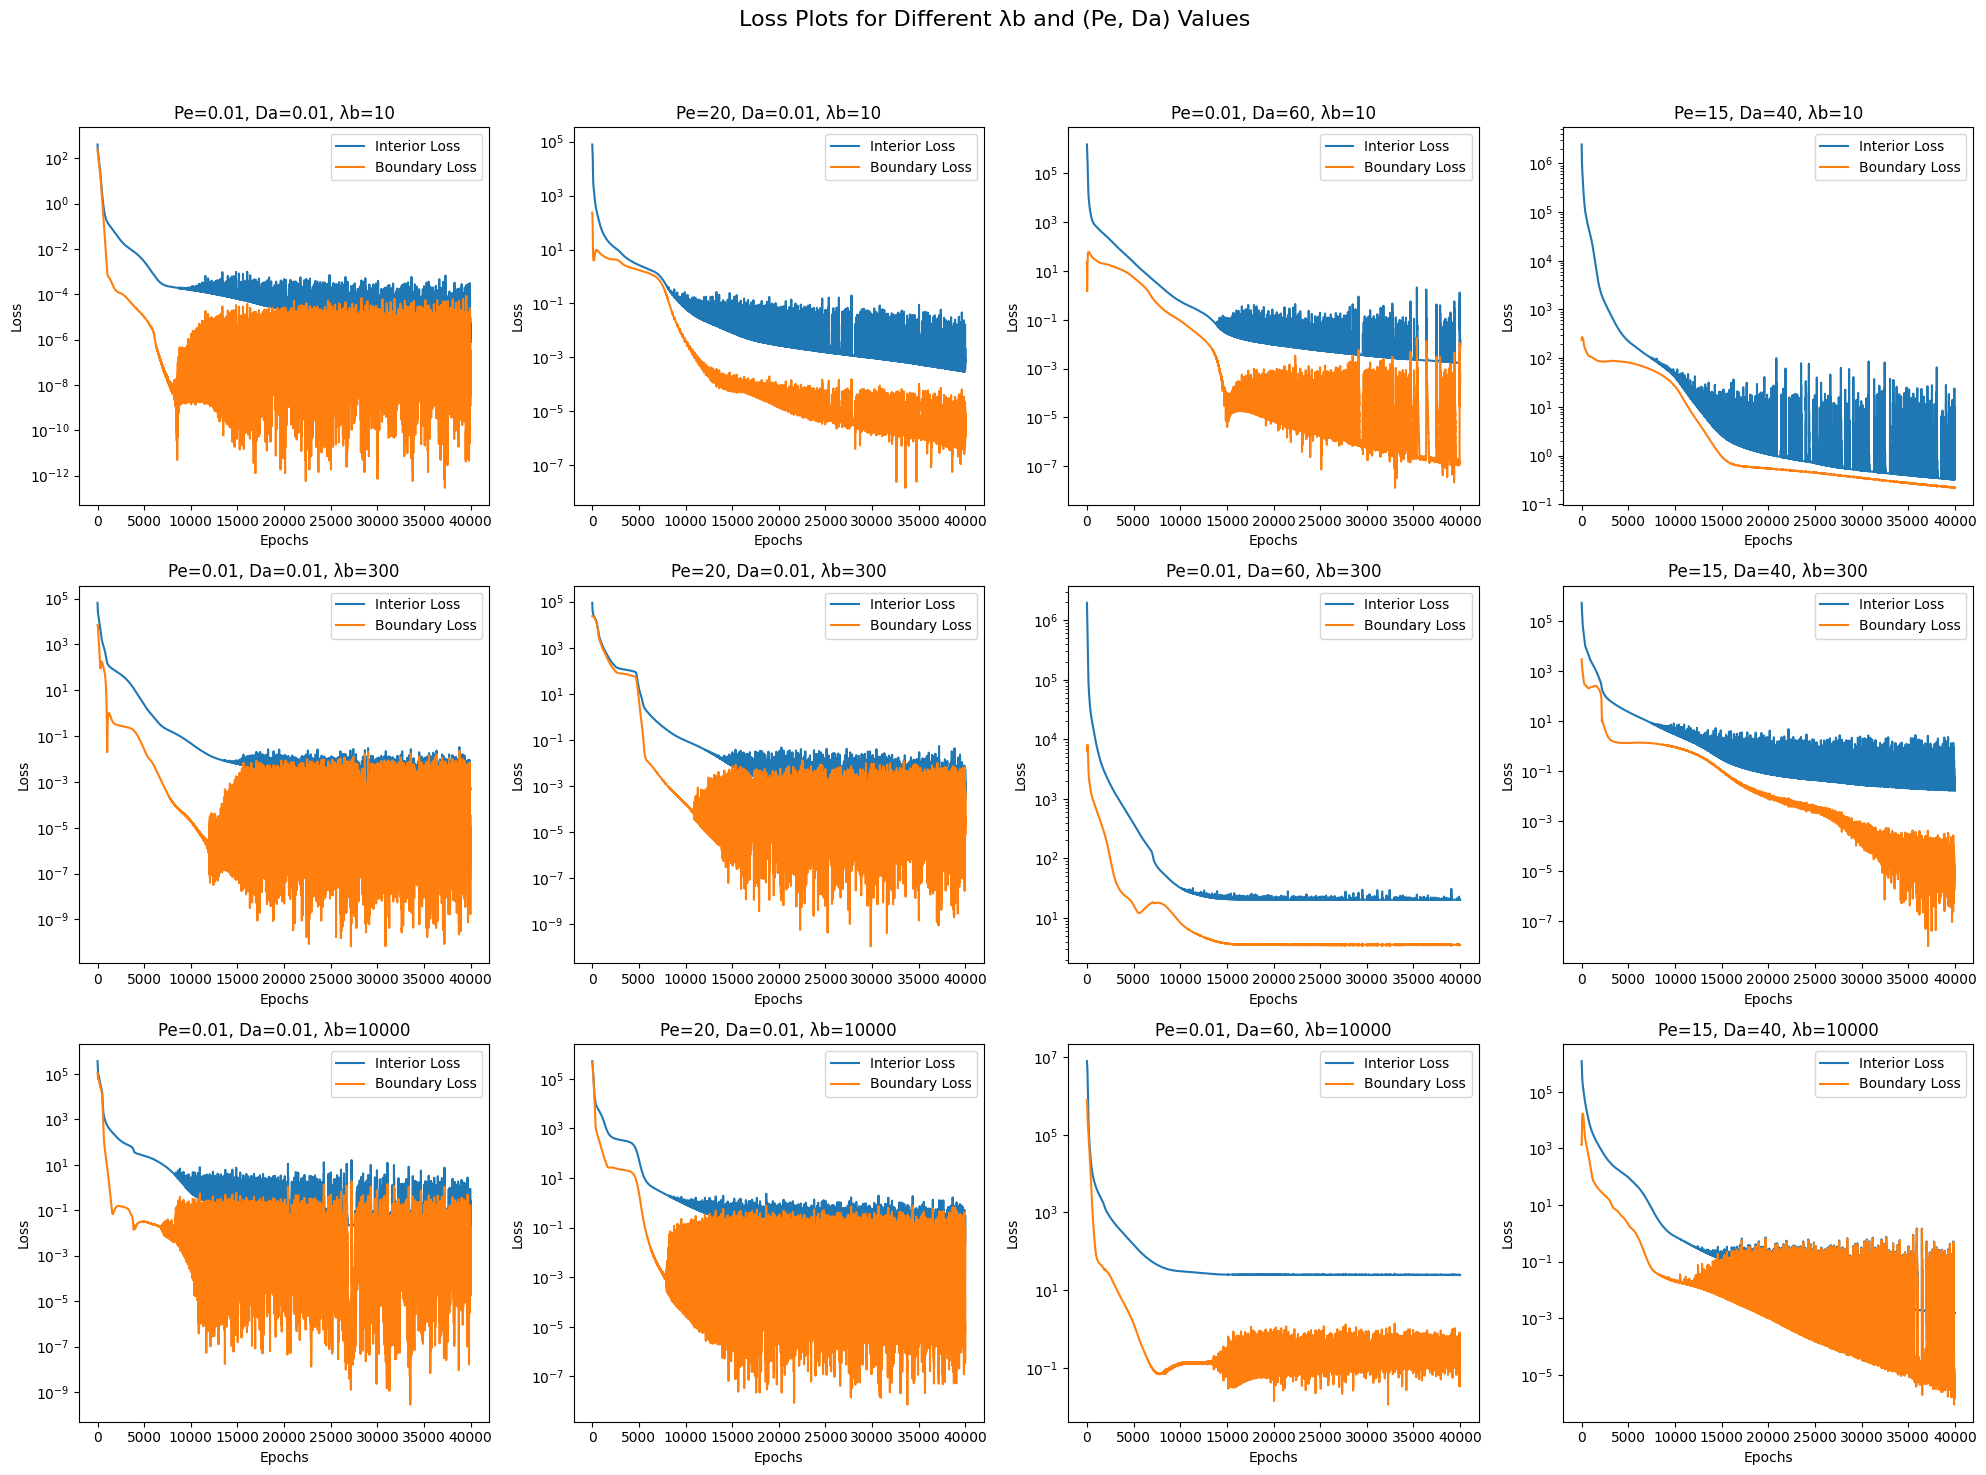

In [51]:
import matplotlib.pyplot as plt

# plot loss
fig, axes = plt.subplots(len(lb_values), 4, figsize=(20, 5 * len(lb_values)))
fig.suptitle("Loss Plots for Different λb and (Pe, Da) Values", fontsize=16)

for i, lb_value in enumerate(lb_values):
    for j, (Pe, Da) in enumerate(param_sets):
        history = results[lb_value][(Pe, Da)]["history"]

        ax = axes[i, j]
        ax.plot(history['interior_loss'], label='Interior Loss')
        ax.plot(history['boundary_loss'], label='Boundary Loss')
        ax.set_yscale("log")
        ax.set_title(f'Pe={Pe}, Da={Da}, λb={lb_value}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Which set of parameter values is the hardest to solve for?

We can see from the plots that when Pe=0.01 and Da=60, the overall loss decreases relatively quickly.

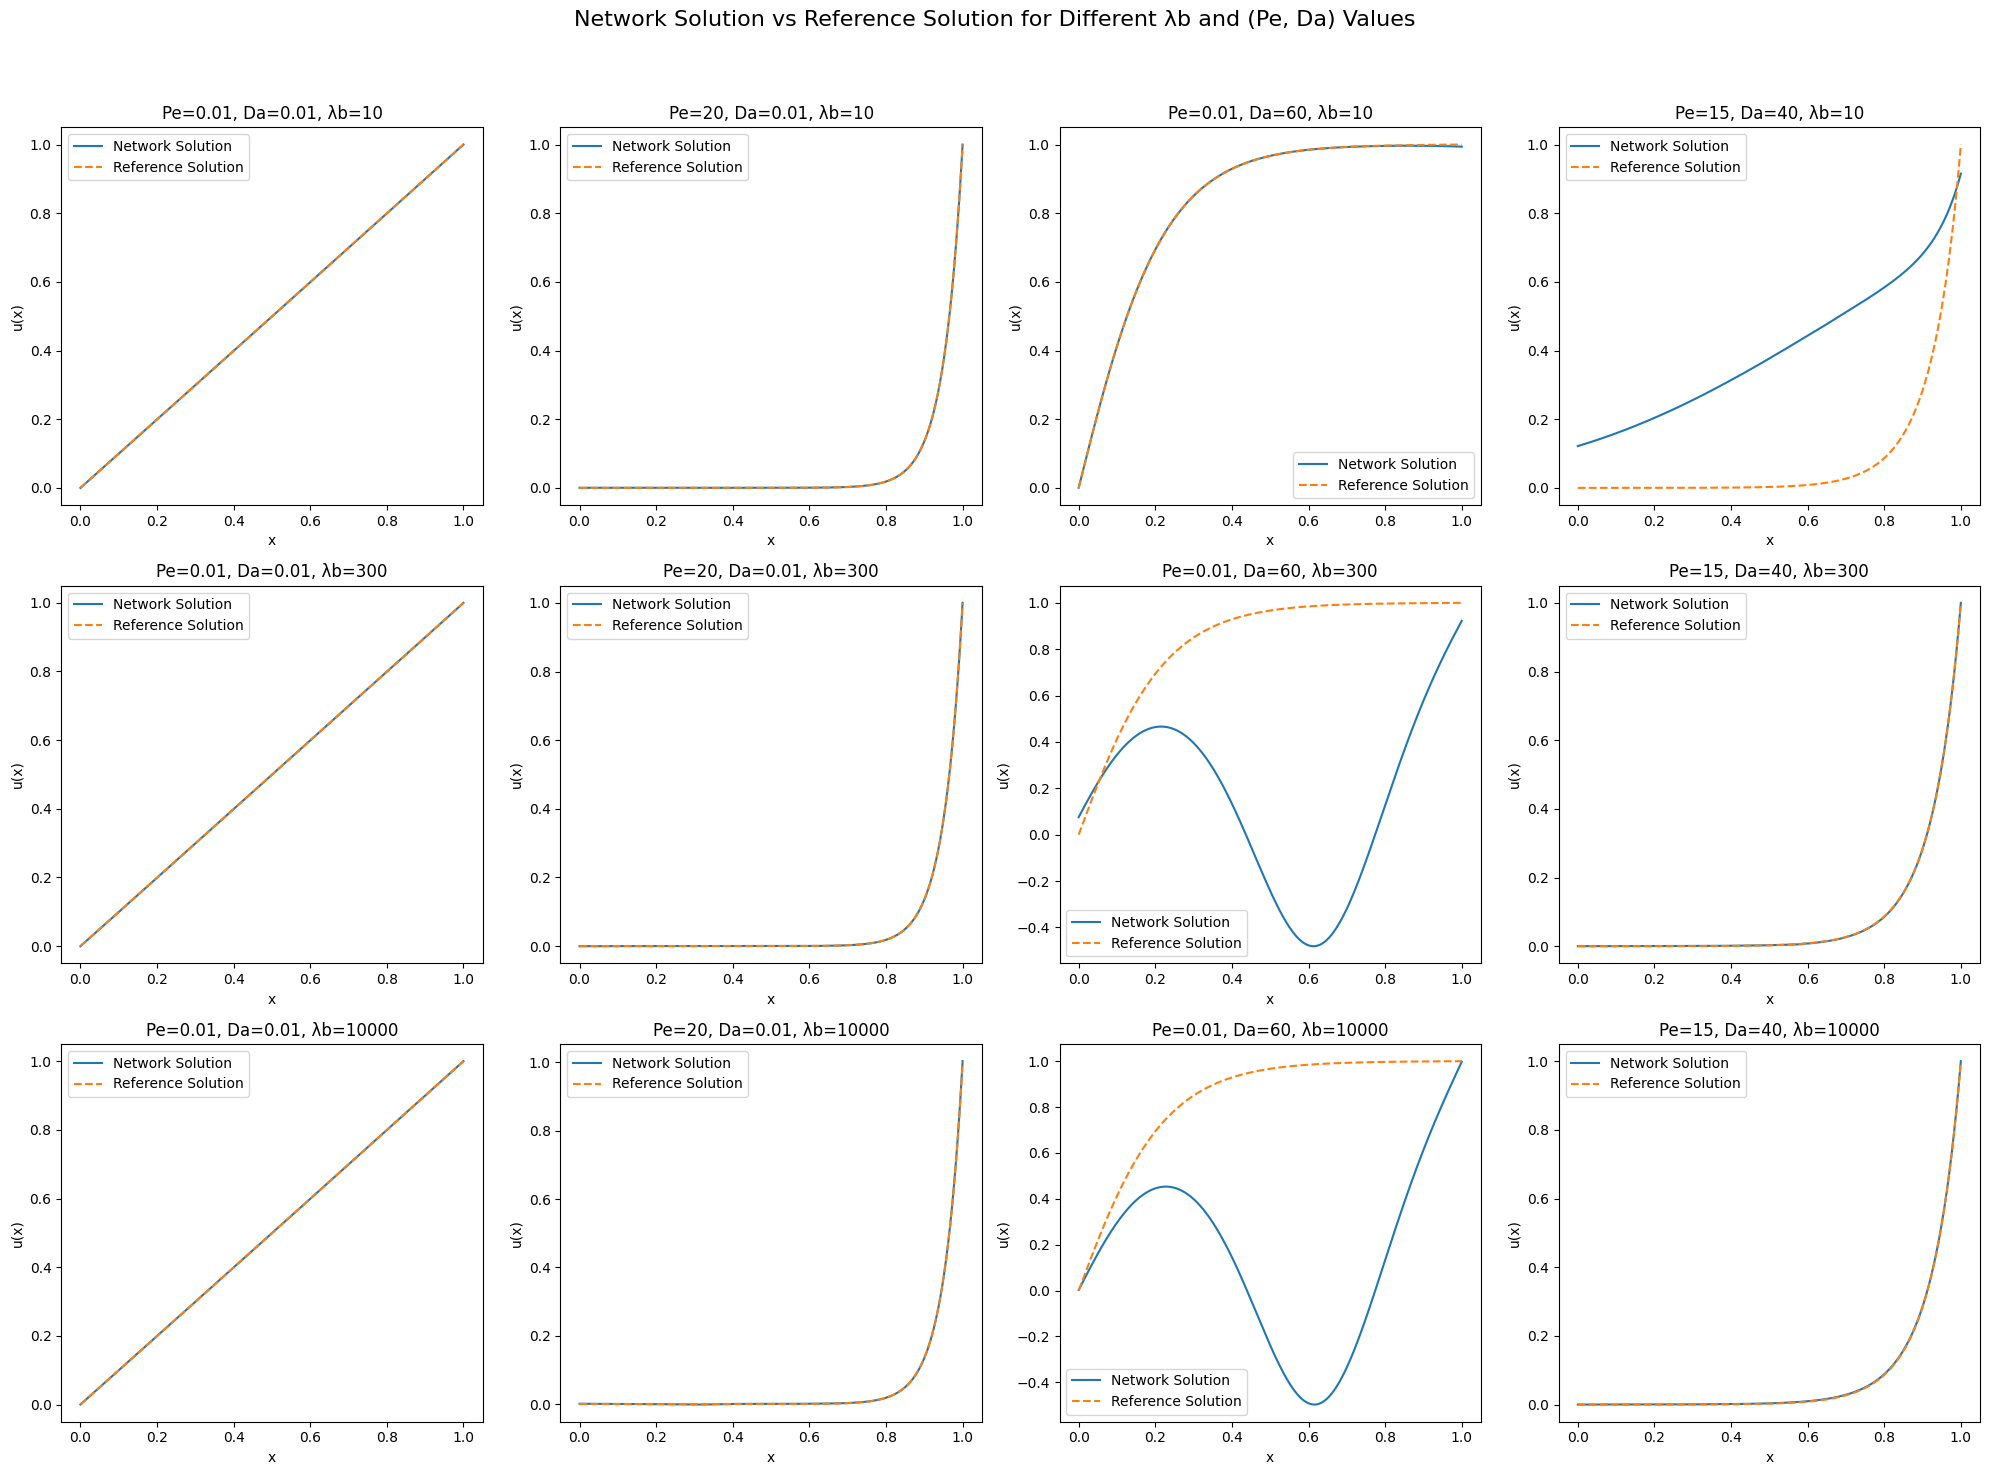

In [53]:
# plot contrast
fig, axes = plt.subplots(len(lb_values), 4, figsize=(20, 5 * len(lb_values)))
fig.suptitle("Network Solution vs Reference Solution for Different λb and (Pe, Da) Values", fontsize=16)

for i, lb_value in enumerate(lb_values):
    for j, (Pe, Da) in enumerate(param_sets):

        test_points = results[lb_value][(Pe, Da)]["test_points"]
        u_pred = results[lb_value][(Pe, Da)]["u_pred"]
        reference_solution = results[lb_value][(Pe, Da)]["reference_solution"]

        ax = axes[i, j]
        ax.plot(test_points, u_pred, label="Network Solution")
        ax.plot(test_points, reference_solution, label="Reference Solution", linestyle="--")
        ax.set_xlabel('x')
        ax.set_ylabel('u(x)')
        ax.set_title(f'Pe={Pe}, Da={Da}, λb={lb_value}')
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Does the same value of λb work for all sets of parameter values? Provide a justification for your observations.

No. For Pe=0.01, Da=0.01 and Pe=20, Da=0.01, all three different λ values perform well. However, for Pe=0.01, Da=60, only λ=10 achieves good results. For Pe=15, Da=40, λ=300 and λ=10000 perform well.